In [1]:
import sys, os
sys.path = [os.path.dirname(os.getcwd())] + sys.path
import json
from itertools import permutations

import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import AllChem

import rdradical
from rdradical.main import rdradicalRun, rdradicalRunText, rdradicalReaction, rdradicalReactants

In [2]:
RDKIT_SMILES_PARSER_PARAMS = Chem.SmilesParserParams()
def str_to_mol(string: str, explicit_hydrogens: bool = True) -> Chem.Mol:

    if string.startswith('InChI'):
        mol = Chem.MolFromInchi(string, removeHs=not explicit_hydrogens)
    else:
        # Set params here so we don't remove hydrogens with atom mapping
        RDKIT_SMILES_PARSER_PARAMS.removeHs = not explicit_hydrogens
        mol = Chem.MolFromSmiles(string, RDKIT_SMILES_PARSER_PARAMS)

    if explicit_hydrogens:
        return mol
        #return Chem.AddHs(mol)
    else:
        return Chem.RemoveHs(mol)

In [3]:
with open('data/test_reactions.json') as f:
    reactions = json.load(f)
with open('data/test_temp.json') as f:
    templates = json.load(f)
print(reactions[:3])
print(templates[:3])

[{'_id': 0, 'reactants': '[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C@:3]2([H:11])[O:4][C@:5]2([H:12])[C:6]1([H:13])[H:14]', 'products': '[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C@@:3]([C:5][H:12])([H:11])[O:4][C:6]1([H:13])[H:14]', 'spectators': '', 'source': 'b97d3', 'source_id': '85c7aac47ee49ff353391df4c0e03800f4d0a93fd885aad5e74b5876c98f8883'}, {'_id': 1, 'reactants': '[C:1](#[C:2][c:3]1[c:4]([H:9])[n:5][n:6][n:7]1[H:10])[H:8]', 'products': '[C:1](=[C:2]=[C:3]1[C:4]([H:9])=[N:5][N:6]=[N:7]1)([H:8])[H:10]', 'spectators': '', 'source': 'b97d3', 'source_id': 'b9160685471963b4f7ac1022612ab80f0e355f5e1db83693172864adbd539771'}, {'_id': 2, 'reactants': '[C:1]([C@@:2]1([H:11])[C:3]([H:12])([H:13])[C@:4]1([C:5]([C:6](=[O:7])[H:17])([H:15])[H:16])[H:14])([H:8])([H:9])[H:10]', 'products': '[C:1]([C:2]([C:3]([C:4][C:5]([C:6](=[O:7])[H:17])([H:15])[H:16])([H:12])[H:13])([H:11])[H:14])([H:8])([H:9])[H:10]', 'spectators': '', 'source': 'b97d3', 'source_id': '9616aae68d8cf21709535c397338e255ae62

In [4]:

if len(reactions) == len(templates):
    products_rdradical = {}
    products = {}
    error = []
    for i in range(0, len(reactions)):
        print(' the {}th itr'.format(i))
        outcomes = []
        reaction_temp = templates[i]['reaction_smarts']
        rad_rt = templates[i]['react_temp_radical']
        rad_pt = templates[i]['prod_temp_radical']
        reactants = reactions[i]['reactants']
        if '.' in reactants:
            reactants = reactants.split('.')
            r_num = len(reactants)
            rt_num = len(reaction_temp.split('>')[0].split('.'))
            if rt_num == r_num :
                for comb in permutations(range(0, rt_num), r_num):
                    reacts = ''
                    for comb_i in comb:
                        reacts = reacts + reactants[comb_i] + '.'
                    reacts = reacts[:-1]
                    outcomes_rdradical, mapped_outcome, mapped_outcome_dup  = rdradicalRunText(reaction_temp,rad_rt,rad_pt, reacts)
                    #print(mapped_outcome)
                    outcomes.append(mapped_outcome_dup)
                    if not mapped_outcome:
                        print(reaction_temp,reacts)
                products_rdradical[i] = outcomes
                print(products_rdradical[i])
                products[i] = reactions[i]['products']
            else:
                error.append(i)
        else:
            outcomes_rdradical, mapped_outcome,mapped_outcomes_dup = rdradicalRunText(reaction_temp,rad_rt,rad_pt, reactants)
            products_rdradical[i] = mapped_outcomes_dup
            print(products_rdradical[i])
            products[i] = Chem.MolToSmiles(str_to_mol(reactions[i]['products']))
print("*****************************************************************")
count = 0
sum_num = 0
err = {}
for i in range(0, len(reactions)):
    if any(products[i] in prods for prods in products_rdradical[i]):
        count = count+1
    else:
        err[i] = (products[i],products_rdradical[i] )
    sum_num = sum_num + 1
print("Total reaction is: {}. Correct Reaction is: {}".format(sum_num, count))
print(err)


 the 0th itr
['[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C@@:3]([C:5][H:12])([H:11])[O:4][C:6]1([H:13])[H:14]', '[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C@@:3]([C:5][H:12])([H:11])[O:4][C:6]1([H:13])[H:14]', '[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[O:4][C@@:5]([C:3][H:11])([H:12])[C:6]1([H:13])[H:14]', '[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[O:4][C@@:5]([C:3][H:11])([H:12])[C:6]1([H:13])[H:14]']
 the 1th itr
['[C:1](=[C:2]=[C:3]1[C:4]([H:9])=[N:5][N:6]=[N:7]1)([H:8])[H:10]']
 the 2th itr
['[C:1]([C:2]([C:3]([C:4][C:5]([C:6](=[O:7])[H:17])([H:15])[H:16])([H:12])[H:13])([H:11])[H:14])([H:8])([H:9])[H:10]']
 the 3th itr
['[N:1]#[C:2][C:4](/[C:3](=[N:7]/[H:12])[H:8])([H:9])[H:10].[N:5]#[C:6][H:11]', '[N:1]#[C:2][C:4](/[C:3](=[N:7]/[H:12])[H:8])([H:9])[H:10].[N:5]#[C:6][H:11]']
 the 4th itr
['[C:1]([C@@:2]1([H:11])[C:3]([H:12])([H:13])[C@@:4]([C:5][H:15])([O:6][H:14])[C:7]1([H:16])[H:17])([H:8])([H:9])[H:10]', '[C:1]([C@@:2]1([H:11])[C:3]([H:12])([H:13])[C@@:4]([C:5][H:15])([O:6][H:14])[

['[C+:1](=[C:2]=[C-:3][C:5]([C:4]([H:7])([H:8])[H:9])([H:10])[H:11])[H:6]', '[C+:1](=[C:2]=[C-:3][C:5]([C:4]([H:7])([H:8])[H:9])([H:10])[H:11])[H:6]', '[C+:1](=[C:2]=[C-:3][C:4]([C:5]([H:7])([H:10])[H:11])([H:8])[H:9])[H:6]', '[C+:1](=[C:2]=[C-:3][C:4]([C:5]([H:7])([H:10])[H:11])([H:8])[H:9])[H:6]']
 the 23th itr
['[C:1]([C@@:4]1([H:11])[C:3]([H:10])=[N:2][C:6]([H:13])=[C:5]1[H:12])([H:7])([H:8])[H:9]', '[C:1]([C@@:4]1([H:11])[C:3]([H:10])=[N:2][C:6]([H:13])=[C:5]1[H:12])([H:7])([H:8])[H:9]', '[C:1]([C@@:4]1([H:11])[C:3]([H:10])=[N:2][C:6]([H:13])=[C:5]1[H:12])([H:7])([H:8])[H:9]', '[C:1]([C@@:4]1([H:11])[C:3]([H:10])=[N:2][C:6]([H:13])=[C:5]1[H:12])([H:7])([H:8])[H:9]', '[C:1]([C@@:4]1([H:11])[C:3]([H:10])=[N:2][C:6]([H:13])=[C:5]1[H:12])([H:7])([H:8])[H:9]', '[C:1]([C@@:4]1([H:11])[C:3]([H:10])=[N:2][C:6]([H:13])=[C:5]1[H:12])([H:7])([H:8])[H:9]', '[C:1]([C@:5]1([H:12])[C:4]([H:11])=[C:3]([H:10])[N:2]=[C:6]1[H:13])([H:7])([H:8])[H:9]', '[C:1]([C@:5]1([H:12])[C:4]([H:11])=[C:3]([H:10]

['[N:1]([c:2]1[n:3]2[c:4]([H:10])[n:5][n:6]2[n:7]1)([H:8])[H:9]', '[N:1]([c:2]1[n:3]2[c:4]([H:10])[n:5][n:6]2[n:7]1)([H:8])[H:9]']
 the 33th itr
['[C:2](=[O:3])=[N:4][C:5](=[O:6])[H:10].[N:1]([H:7])([H:8])[H:9]', '[C:2](=[O:3])=[N:4][C:5](=[O:6])[H:10].[N:1]([H:7])([H:8])[H:9]']
 the 34th itr
['[C:1]([C:2](=[C:3]=[C:4]([C:5](=[O:6])[H:12])[H:11])[H:10])([H:7])([H:8])[H:9]']
 the 35th itr
['[H:8][H:15].[O:1]1[C@@:2]2([H:9])[C:3]([H:10])([H:11])[C:4]([H:12])([H:13])[C:5]([H:14])=[C:6]([H:16])[C@@:7]12[H:17]', '[H:8][H:14].[O:1]1[C@@:2]2([H:9])[C:3]([H:10])([H:11])[C:4]([H:12])([H:13])[C:5]([H:15])=[C:6]([H:16])[C@@:7]12[H:17]']
 the 36th itr
['[C:1]([O+:2]=[C-:3][H:10])([H:7])([H:8])[H:9].[C:4]1([H:11])([H:12])[C:5]([H:13])([H:14])[N:6]1[H:15]', '[C:1]([O+:2]=[C-:3][H:11])([H:7])([H:8])[H:9].[C:4]1([H:10])([H:12])[C:5]([H:13])([H:14])[N:6]1[H:15]']
 the 37th itr
['[O:1]([C:2]([C:3](=[C:4])[C:5]#[C:6][H:10])([H:8])[H:9])[H:7]']
 the 38th itr
['[C:1]([C@:2]12[C:3]([H:11])=[C:4]([H:13])[C:5

['[C:1]([O:2][H:9])(/[C:5](=[C:4](\\[C:3][H:8])[H:10])[H:11])([H:6])[H:7]', '[C:1]([O:2][H:8])(/[C:5](=[C:4](\\[C:3][H:9])[H:10])[H:11])([H:6])[H:7]', '[C:1](/[C:5](=[C:4](\\[C:3]([O:2][H:7])([H:8])[H:9])[H:10])[H:11])[H:6]', '[C:1](/[C:5](=[C:4](\\[C:3]([O:2][H:6])([H:8])[H:9])[H:10])[H:11])[H:7]']
 the 62th itr
['[C:1]([C:2]([O:3][C:4]([H:8])([H:12])[H:13])([H:10])[H:11])(=[C:7]([H:16])[H:17])[H:9].[C:5](#[C:6][H:15])[H:14]', '[C:1]([C:2]([O:3][C:4]([H:8])([H:12])[H:13])([H:10])[H:11])(=[C:7]([H:16])[H:17])[H:9].[C:5](#[C:6][H:15])[H:14]', '[C:1]([C:2]([O:3][C:4]([H:9])([H:12])[H:13])([H:10])[H:11])(=[C:7]([H:16])[H:17])[H:8].[C:5](#[C:6][H:15])[H:14]', '[C:1]([C:2]([O:3][C:4]([H:9])([H:12])[H:13])([H:10])[H:11])(=[C:7]([H:16])[H:17])[H:8].[C:5](#[C:6][H:15])[H:14]', '[C:1]([C:2]([O:3][C:4]([H:8])([H:12])[H:13])([H:10])[H:11])(=[C:7]([H:16])[H:17])[H:9].[C:5](#[C:6][H:15])[H:14]', '[C:1]([C:2]([O:3][C:4]([H:8])([H:12])[H:13])([H:10])[H:11])(=[C:7]([H:16])[H:17])[H:9].[C:5](#[C:6][H:1

['[C:1]([C:2]([N+:3]#[C-:4])([H:10])[H:11])([H:7])([H:8])[H:9].[O:5]([C:6]([H:13])([H:14])[H:15])[H:12]']
 the 81th itr
['[O+:1](=[C-:2][H:7])[C:3]([C:4]([C:5]#[N:6])([H:10])[H:11])([H:8])[H:9]', '[O+:1](=[C-:2][H:7])[C:3]([C:4]([C:5]#[N:6])([H:10])[H:11])([H:8])[H:9]']
 the 82th itr
['[C:1]([C:2]([C@@:7]1([H:17])[C:3][C:4]([H:13])([H:14])[C:5]([H:15])=[C:6]1[H:16])([H:11])[H:12])([H:8])([H:9])[H:10]']
 the 83th itr
['[C:1]([C:2]([O:3][C:5]1=[N:6][C:4]1([H:12])[H:13])([H:10])[H:11])([H:7])([H:8])[H:9]', '[C:1]([C:2]([O:3][C:5]1=[N:6][C:4]1([H:12])[H:13])([H:10])[H:11])([H:7])([H:8])[H:9]']
 the 84th itr
['[C:3](=[C:4]([H:9])[H:10])([C:6]([O:5][H:7])([H:11])[H:12])[H:8].[O+:1]#[C-:2]', '[C:3](=[C:4]([H:9])[H:10])([C:6]([O:5][H:7])([H:11])[H:12])[H:8].[O+:1]#[C-:2]', '[C:3]([C:4]([O:5][H:7])([H:9])[H:10])(=[C:6]([H:11])[H:12])[H:8].[O+:1]#[C-:2]', '[C:3]([C:4]([O:5][H:7])([H:9])[H:10])(=[C:6]([H:11])[H:12])[H:8].[O+:1]#[C-:2]']
 the 85th itr
['[O:1]1[C@:2](/[C:3](=[N:5]\\[C:6](=[O:7])[H:

['[C:1]([H:7])([H:8])([H:9])[H:10].[C:2]([O:3][H:11])[C:4]1([H:12])[C:5]([H:13])([H:14])[C:6]1([H:15])[H:16]', '[C:1]([H:7])([H:8])([H:9])[H:10].[C:2]([O:3][H:11])[C:4]1([H:12])[C:5]([H:13])([H:14])[C:6]1([H:15])[H:16]', '[C:1]([H:7])([H:8])([H:9])[H:10].[C:2]([O:3][H:11])[C:4]1([H:12])[C:5]([H:13])([H:14])[C:6]1([H:15])[H:16]', '[C:1]([H:7])([H:8])([H:9])[H:10].[C:2]([O:3][H:11])[C:4]1([H:12])[C:5]([H:13])([H:14])[C:6]1([H:15])[H:16]', '[C:1]([H:7])([H:8])([H:9])[H:10].[C:2]([O:3][H:11])[C:4]1([H:12])[C:5]([H:13])([H:14])[C:6]1([H:15])[H:16]', '[C:1]([H:7])([H:8])([H:9])[H:10].[C:2]([O:3][H:11])[C:4]1([H:12])[C:5]([H:13])([H:14])[C:6]1([H:15])[H:16]']
 the 100th itr
['[C:1]([C:2]#[C:3][H:11])([H:7])([H:8])[H:9].[C:4](=[O:5])=[N:6][H:10]', '[C:1]([C:2]#[C:3][H:10])([H:7])([H:8])[H:9].[C:4](=[O:5])=[N:6][H:11]']
 the 101th itr
['[C:1]([C:2](=[C:3]([H:13])[H:14])[C@@:4]([C:5]([H:16])([H:17])[H:18])([C:6]#[N:7])[H:15])([H:8])([H:9])[H:10].[H:11][H:12]', '[C:1]([C:2](=[C:3]([H:13])[H:14])[

['[C:1]([C:2]([C:4](=[C:3]([H:13])[H:14])[H:15])([H:11])[H:12])([H:8])([H:9])[H:10].[C:5](=[C:6]([O:7][H:19])[H:18])([H:16])[H:17]', '[C:1]([C:2]([C:4](=[C:3]([H:13])[H:14])[H:15])([H:11])[H:12])([H:8])([H:9])[H:10].[C:5](=[C:6]([O:7][H:19])[H:18])([H:16])[H:17]', '[C:1]([C:2]([C:4](=[C:3]([H:13])[H:14])[H:15])([H:11])[H:12])([H:8])([H:9])[H:10].[C:5](=[C:6]([O:7][H:19])[H:18])([H:16])[H:17]', '[C:1]([C:2]([C:4](=[C:3]([H:13])[H:14])[H:15])([H:11])[H:12])([H:8])([H:9])[H:10].[C:5](=[C:6]([O:7][H:19])[H:18])([H:16])[H:17]', '[C:1]([C:2]([C:4](=[C:3]([H:13])[H:14])[H:15])([H:11])[H:12])([H:8])([H:9])[H:10].[C:5](=[C:6]([O:7][H:19])[H:18])([H:16])[H:17]', '[C:1]([C:2]([C:4](=[C:3]([H:13])[H:14])[H:15])([H:11])[H:12])([H:8])([H:9])[H:10].[C:5](=[C:6]([O:7][H:19])[H:18])([H:16])[H:17]', '[C:1]([C:2]([C:4](=[C:3]([H:13])[H:14])[H:15])([H:11])[H:12])([H:8])([H:9])[H:10].[C:5](=[C:6]([O:7][H:19])[H:18])([H:16])[H:17]', '[C:1]([C:2]([C:4](=[C:3]([H:13])[H:14])[H:15])([H:11])[H:12])([H:8])([H:9]

['[C:1]([O+:2]=[C-:3][O:4][C:5](=[O:6])[H:10])([H:7])([H:8])[H:9]']
 the 146th itr
['[C:1](/[C:2](=[N:3]/[C@@:4]([C:5]([H:13])([H:14])[H:15])([C:6]#[N:7])[H:12])[H:11])([H:8])([H:9])[H:10]']
 the 147th itr
['[C:5](=[O:6])([H:10])[H:11].[N:1](=[C:2]=[O+:3][C-:4]([H:8])[H:9])[H:7]', '[C:5](=[O:6])([H:10])[H:11].[N:1](=[C:2]=[O+:3][C-:4]([H:8])[H:9])[H:7]', '[C:5](=[O:6])([H:10])[H:11].[N:1](=[C:2]=[O+:3][C-:4]([H:8])[H:9])[H:7]', '[C:5](=[O:6])([H:10])[H:11].[N:1](=[C:2]=[O+:3][C-:4]([H:8])[H:9])[H:7]', '[N:1](=[C:2]=[O+:6][C-:5]([H:10])[H:11])[H:7].[O:3]=[C:4]([H:8])[H:9]', '[N:1](=[C:2]=[O+:6][C-:5]([H:10])[H:11])[H:7].[O:3]=[C:4]([H:8])[H:9]', '[N:1](=[C:2]=[O+:6][C-:5]([H:10])[H:11])[H:7].[O:3]=[C:4]([H:8])[H:9]', '[N:1](=[C:2]=[O+:6][C-:5]([H:10])[H:11])[H:7].[O:3]=[C:4]([H:8])[H:9]']
 the 148th itr
['[C:1]([C:2]([C:3]([H:12])([H:13])[H:14])=[C:4]([H:15])[H:16])([H:8])([H:9])[H:10].[C:5](=[C:6]([H:18])[H:19])([C:7]([H:11])([H:20])[H:21])[H:17]', '[C:1]([C:2]([C:3]([H:12])([H:13])[H:

['[C:1]([C:2](=[C:3]([H:10])[H:11])[C:5]#[C:6][H:14])([H:7])([H:8])[H:9].[O:4]([H:12])[H:13]', '[C:1]([C:2](=[C:3]([H:10])[H:12])[C:5]#[C:6][H:14])([H:7])([H:8])[H:9].[O:4]([H:11])[H:13]', '[C:1]([C:2](=[C:3]([H:10])[H:11])[C:5]#[C:6][H:14])([H:7])([H:8])[H:9].[O:4]([H:12])[H:13]', '[C:1]([C:2](=[C:3]([H:11])[H:12])[C:5]#[C:6][H:14])([H:7])([H:8])[H:9].[O:4]([H:10])[H:13]', '[C:1]([C:2](=[C:3]([H:10])[H:12])[C:5]#[C:6][H:14])([H:7])([H:8])[H:9].[O:4]([H:11])[H:13]', '[C:1]([C:2](=[C:3]([H:11])[H:12])[C:5]#[C:6][H:14])([H:7])([H:8])[H:9].[O:4]([H:10])[H:13]', '[C:1](=[C:2]([C:3]([H:10])([H:11])[H:12])[C:5]#[C:6][H:14])([H:7])[H:8].[O:4]([H:9])[H:13]', '[C:1](=[C:2]([C:3]([H:10])([H:11])[H:12])[C:5]#[C:6][H:14])([H:7])[H:9].[O:4]([H:8])[H:13]', '[C:1](=[C:2]([C:3]([H:10])([H:11])[H:12])[C:5]#[C:6][H:14])([H:7])[H:8].[O:4]([H:9])[H:13]', '[C:1](=[C:2]([C:3]([H:10])([H:11])[H:12])[C:5]#[C:6][H:14])([H:8])[H:9].[O:4]([H:7])[H:13]', '[C:1](=[C:2]([C:3]([H:10])([H:11])[H:12])[C:5]#[C:6][H:14]

['[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:7])([H:13])[H:14])([H:15])[H:16])([H:8])[H:9]', '[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:7])([H:13])[H:14])([H:15])[H:16])([H:8])[H:9]', '[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:8])([H:13])[H:14])([H:15])[H:16])([H:7])[H:9]', '[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:8])([H:13])[H:14])([H:15])[H:16])([H:7])[H:9]', '[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:9])([H:13])[H:14])([H:15])[H:16])([H:7])[H:8]', '[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:9])([H:13])[H:14])([H:15])[H:16])([H:7])[H:8]', '[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:7])([H:13])[H:14])([H:15])[H:16])([H:8])[H:9]', '[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:7])([H:13])[H:14])([H:15])[H:16])([H:8])[H:9]', '[C-:1]([O+:2]=[C:3]([C:4]([H:10])([H:11])[H:12])[C:6]([C:5]([H:8])([H:13])[H:14])([H:15])[H:16])([H:7]

['[C:1](=[O+:2][C:3]([C:4]([H:11])([H:12])[H:13])=[C:6]=[N-:7])([H:8])[H:9].[C:5]([H:10])([H:14])([H:15])[H:16]', '[C:1](=[O+:2][C:3]([C:4]([H:11])([H:12])[H:13])=[C:6]=[N-:7])([H:8])[H:9].[C:5]([H:10])([H:14])([H:15])[H:16]', '[C:1](=[O+:2][C:3]([C:4]([H:11])([H:12])[H:13])=[C:6]=[N-:7])([H:8])[H:9].[C:5]([H:10])([H:14])([H:15])[H:16]', '[C:1](=[O+:2][C:3]([C:4]([H:11])([H:12])[H:13])=[C:6]=[N-:7])([H:8])[H:9].[C:5]([H:10])([H:14])([H:15])[H:16]', '[C:1](=[O+:2][C:3]([C:4]([H:11])([H:12])[H:13])=[C:6]=[N-:7])([H:8])[H:9].[C:5]([H:10])([H:14])([H:15])[H:16]', '[C:1](=[O+:2][C:3]([C:4]([H:11])([H:12])[H:13])=[C:6]=[N-:7])([H:8])[H:9].[C:5]([H:10])([H:14])([H:15])[H:16]', '[C:1](=[O+:2][C:3]([C:5]([H:14])([H:15])[H:16])=[C:6]=[N-:7])([H:8])[H:9].[C:4]([H:10])([H:11])([H:12])[H:13]', '[C:1](=[O+:2][C:3]([C:5]([H:14])([H:15])[H:16])=[C:6]=[N-:7])([H:8])[H:9].[C:4]([H:10])([H:11])([H:12])[H:13]', '[C:1](=[O+:2][C:3]([C:5]([H:14])([H:15])[H:16])=[C:6]=[N-:7])([H:8])[H:9].[C:4]([H:10])([H:11]

['[C:1](=[C:2]([H:9])[H:10])([H:7])[H:8].[N:3](=[C:4](\\[C:5]#[C:6][H:13])[H:12])\\[H:11]', '[C:1](=[C:2]([H:8])[H:10])([H:7])[H:9].[N:3](=[C:4](\\[C:5]#[C:6][H:13])[H:12])\\[H:11]', '[C:1](=[C:2]([H:9])[H:10])([H:7])[H:8].[N:3](=[C:4](\\[C:5]#[C:6][H:13])[H:12])\\[H:11]', '[C:1](=[C:2]([H:7])[H:10])([H:8])[H:9].[N:3](=[C:4](\\[C:5]#[C:6][H:13])[H:12])\\[H:11]', '[C:1](=[C:2]([H:8])[H:10])([H:7])[H:9].[N:3](=[C:4](\\[C:5]#[C:6][H:13])[H:12])\\[H:11]', '[C:1](=[C:2]([H:7])[H:10])([H:8])[H:9].[N:3](=[C:4](\\[C:5]#[C:6][H:13])[H:12])\\[H:11]']
 the 213th itr
['[C:1]([O:2][C:3]([C:5]([H:14])([H:15])[H:16])=[C:6]=[N:7][C:4]([H:11])([H:12])[H:13])([H:8])([H:9])[H:10]', '[C:1]([O:2][C:3]([C:5]([H:14])([H:15])[H:16])=[C:6]=[N:7][C:4]([H:11])([H:12])[H:13])([H:8])([H:9])[H:10]', '[C:1]([O:2][C:3]([C:5]([H:14])([H:15])[H:16])=[C:6]=[N:7][C:4]([H:11])([H:12])[H:13])([H:8])([H:9])[H:10]', '[C:1]([O:2][C:3]([C:5]([H:14])([H:15])[H:16])=[C:6]=[N:7][C:4]([H:11])([H:12])[H:13])([H:8])([H:9])[H:10]', '

['[O:1]([c:2]1[c:3]([H:7])[c:4]([H:9])[c:5]([H:10])[n:6]1[H:11])[H:8]', '[O:1]([c:2]1[c:3]([H:8])[c:4]([H:9])[c:5]([H:10])[n:6]1[H:11])[H:7]']
 the 266th itr
['[C-:6]#[O+:7].[O:1]([C:2](/[C:3](=[C:4](/[C:5]([H:13])([H:14])[H:15])[H:12])[H:11])([H:9])[H:10])[H:8]', '[C-:6]#[O+:7].[O:1]([C:2](/[C:3](=[C:4](/[C:5]([H:12])([H:14])[H:15])[H:13])[H:11])([H:9])[H:10])[H:8]', '[C-:6]#[O+:7].[O:1]([C:2](/[C:3](=[C:4](/[C:5]([H:13])([H:14])[H:15])[H:12])[H:11])([H:9])[H:10])[H:8]', '[C-:6]#[O+:7].[O:1]([C:2](/[C:3](=[C:4](/[C:5]([H:12])([H:14])[H:15])[H:13])[H:11])([H:9])[H:10])[H:8]']
 the 267th itr
['[H:8][H:17].[O:1]=[C:2]([C:7]1=[C:6]([H:16])[C:5]([H:14])([H:15])[C:4]([H:12])([H:13])[C:3]1([H:10])[H:11])[H:9]', '[H:8][H:17].[O:1]=[C:2]([C:7]1=[C:6]([H:16])[C:5]([H:14])([H:15])[C:4]([H:12])([H:13])[C:3]1([H:10])[H:11])[H:9]']
 the 268th itr
['[C:1]([C:2]([C:6]([C:5]([C:4](=[C:3]([H:11])[H:12])[H:13])([H:14])[H:15])([H:16])[H:17])=[O:7])([H:8])([H:9])[H:10]', '[C:1]([C:2]([C:6]([C:5]([C:4](=[C

['[C:1](/[C:2]([O:3][H:10])=[N:4]\\[C:5](=[O:6])[H:11])([H:7])([H:8])[H:9]']
 the 293th itr
['[C:3](=[C:4]([C:6]#[C:7][H:15])[H:13])([H:11])[H:12].[O:1]=[C:2]([H:9])[H:10].[O:5]([H:8])[H:14]', '[C:3](=[C:4]([C:6]#[C:7][H:15])[H:13])([H:11])[H:12].[O:1]=[C:2]([H:9])[H:10].[O:5]([H:8])[H:14]', '[C:3](=[C:4]([C:6]#[C:7][H:15])[H:13])([H:11])[H:12].[O:1]=[C:2]([H:9])[H:10].[O:5]([H:8])[H:14]', '[C:3](=[C:4]([C:6]#[C:7][H:15])[H:13])([H:11])[H:12].[O:1]=[C:2]([H:9])[H:10].[O:5]([H:8])[H:14]']
 the 294th itr
['[C:1](=[C:2]1[O:3][C@:4]1([C:5]([H:11])([H:12])[H:13])[H:10])([H:7])[H:8].[H:6][H:9]', '[C:1](=[C:2]1[O:3][C@:4]1([C:5]([H:11])([H:12])[H:13])[H:10])([H:7])[H:8].[H:6][H:9]', '[C:1](=[C:2]1[O:3][C@:4]1([C:5]([H:11])([H:12])[H:13])[H:10])([H:6])[H:8].[H:7][H:9]', '[C:1](=[C:2]1[O:3][C@:4]1([C:5]([H:11])([H:12])[H:13])[H:10])([H:6])[H:8].[H:7][H:9]', '[C:1](=[C:2]1[O:3][C@:4]1([C:5]([H:11])([H:12])[H:13])[H:10])([H:6])[H:7].[H:8][H:9]', '[C:1](=[C:2]1[O:3][C@:4]1([C:5]([H:11])([H:12])[H:

['[C:1](#[C:2][C-:3]=[O+:5][C:4]([H:7])([H:8])[H:9])[H:6]', '[C:1](#[C:2][C-:3]=[O+:5][C:4]([H:7])([H:8])[H:9])[H:6]']
 the 314th itr
['[C:1]([C:6]([C:4]([N+:3](=[C-:2][H:11])[H:12])=[O:5])([C:7]([H:14])([H:15])[H:16])[H:13])([H:8])([H:9])[H:10]', '[C:1]([C:6]([C:4]([N+:3](=[C-:2][H:11])[H:12])=[O:5])([C:7]([H:14])([H:15])[H:16])[H:13])([H:8])([H:9])[H:10]', '[C:1]([C:6]([C:4]([N+:3](=[C-:2][H:11])[H:12])=[O:5])([C:7]([H:14])([H:15])[H:16])[H:13])([H:8])([H:9])[H:10]', '[C:1]([C:6]([C:4]([N+:3](=[C-:2][H:11])[H:12])=[O:5])([C:7]([H:14])([H:15])[H:16])[H:13])([H:8])([H:9])[H:10]', '[C:1]([C:6]([C:4]([N+:3](=[C-:2][H:11])[H:12])=[O:5])([C:7]([H:14])([H:15])[H:16])[H:13])([H:8])([H:9])[H:10]', '[C:1]([C:6]([C:4]([N+:3](=[C-:2][H:11])[H:12])=[O:5])([C:7]([H:14])([H:15])[H:16])[H:13])([H:8])([H:9])[H:10]']
 the 315th itr
['[O:1]1[C:2]([H:9])([H:10])[C@@:3]([C:4]#[C:5][H:12])([H:11])[C:6]1=[C:7]([H:8])[H:13]', '[O:1]1[C:2]([H:9])([H:10])[C@@:3]([C:6]#[C:7][H:13])([H:11])[C:4]1=[C:5]([H:8])[H

['[O:1]=[C:2]1[O:3][C:4]([H:8])([H:9])[C@@:5]1([O+:7]=[C-:6][H:10])[H:11]', '[O:1]=[C:2]1[O:3][C:4]([H:8])([H:9])[C@@:5]1([O+:7]=[C-:6][H:11])[H:10]']
 the 330th itr
['[C:4](#[N+:5][O-:6])[H:8].[O:1]=[C:2]=[N:3][H:7]']
 the 331th itr
['[N:1](=[C:2]1[C+:3]([H:9])[N:4]([H:10])[N-:5][C:6]1([H:7])[H:11])[H:8]', '[N:1](=[C:2]1[C+:3]([H:9])[N:4]([H:10])[N-:5][C:6]1([H:8])[H:11])[H:7]']
 the 332th itr
['[C:1]([C:2][C:5]([N:4]1[C:3]([H:10])([H:11])[C:6]1([H:14])[H:15])([H:12])[H:13])([H:7])([H:8])[H:9]', '[C:1]([C:2][C:5]([N:4]1[C:3]([H:10])([H:11])[C:6]1([H:14])[H:15])([H:12])[H:13])([H:7])([H:8])[H:9]', '[C:1]([C:2][C:6]([N:4]1[C:3]([H:10])([H:11])[C:5]1([H:12])[H:13])([H:14])[H:15])([H:7])([H:8])[H:9]', '[C:1]([C:2][C:6]([N:4]1[C:3]([H:10])([H:11])[C:5]1([H:12])[H:13])([H:14])[H:15])([H:7])([H:8])[H:9]', '[C:1]([C:2][C:5]([N:4]1[C:3]([H:10])([H:11])[C:6]1([H:14])[H:15])([H:12])[H:13])([H:7])([H:8])[H:9]', '[C:1]([C:2][C:5]([N:4]1[C:3]([H:10])([H:11])[C:6]1([H:14])[H:15])([H:12])[H:13])([H:7

['[C-:2]([C:3]([C+:4]1[C:5]([H:16])([H:17])[C@:6]1([O:7][H:19])[H:18])([H:13])[H:14])([H:11])[H:12].[C:1]([H:8])([H:9])([H:10])[H:15]', '[C-:2]([C:3]([C+:4]1[C:5]([H:16])([H:17])[C@:6]1([O:7][H:19])[H:18])([H:13])[H:14])([H:11])[H:12].[C:1]([H:8])([H:9])([H:10])[H:15]', '[C-:2]([C:3]([C+:4]1[C:5]([H:16])([H:17])[C@:6]1([O:7][H:19])[H:18])([H:13])[H:14])([H:11])[H:12].[C:1]([H:8])([H:9])([H:10])[H:15]', '[C-:2]([C:3]([C+:4]1[C:5]([H:16])([H:17])[C@:6]1([O:7][H:19])[H:18])([H:13])[H:14])([H:11])[H:12].[C:1]([H:8])([H:9])([H:10])[H:15]', '[C-:2]([C:3]([C+:4]1[C:5]([H:16])([H:17])[C@:6]1([O:7][H:19])[H:18])([H:13])[H:14])([H:11])[H:12].[C:1]([H:8])([H:9])([H:10])[H:15]', '[C-:2]([C:3]([C+:4]1[C:5]([H:16])([H:17])[C@:6]1([O:7][H:19])[H:18])([H:13])[H:14])([H:11])[H:12].[C:1]([H:8])([H:9])([H:10])[H:15]', '[C-:2]([C:3]([C+:4]1[C:5]([H:16])([H:17])[C@:6]1([O:7][H:19])[H:18])([H:13])[H:14])([H:11])[H:12].[C:1]([H:8])([H:9])([H:10])[H:15]', '[C-:2]([C:3]([C+:4]1[C:5]([H:16])([H:17])[C@:6]1([O:7

['[C:1]([H:7])([H:8])([H:9])[H:13].[C@:2]12([H:10])[C:3]([H:11])([H:12])[C@:4]1([H:14])[C:5]2([C:6]([H:16])([H:17])[H:18])[H:15]', '[C:1]([H:7])([H:8])([H:9])[H:14].[C@:2]12([H:10])[C:3]([H:11])([H:12])[C@:4]1([H:13])[C:5]2([C:6]([H:16])([H:17])[H:18])[H:15]', '[C:1]([H:7])([H:8])([H:9])[H:13].[C@:2]12([H:10])[C:3]([H:11])([H:12])[C@:4]1([H:14])[C:5]2([C:6]([H:16])([H:17])[H:18])[H:15]', '[C:1]([H:7])([H:8])([H:9])[H:14].[C@:2]12([H:10])[C:3]([H:11])([H:12])[C@:4]1([H:13])[C:5]2([C:6]([H:16])([H:17])[H:18])[H:15]', '[C:1]([H:7])([H:8])([H:9])[H:13].[C@:2]12([H:10])[C:3]([H:11])([H:12])[C@:4]1([H:14])[C:5]2([C:6]([H:16])([H:17])[H:18])[H:15]', '[C:1]([H:7])([H:8])([H:9])[H:14].[C@:2]12([H:10])[C:3]([H:11])([H:12])[C@:4]1([H:13])[C:5]2([C:6]([H:16])([H:17])[H:18])[H:15]', '[C:1]([H:7])([H:8])([H:9])[H:13].[C@:2]12([H:10])[C:3]([H:11])([H:12])[C@:4]1([H:14])[C:5]2([C:6]([H:16])([H:17])[H:18])[H:15]', '[C:1]([H:7])([H:8])([H:9])[H:14].[C@:2]12([H:10])[C:3]([H:11])([H:12])[C@:4]1([H:13])[C:

['[C:1]([C@@:2]1([H:11])[C+:3]([H:12])[C:4]([H:14])=[C-:5][C:6]([H:16])([H:17])[O:7]1)([H:8])([H:9])[H:10].[H:13][H:15]', '[C:1]([C@@:2]1([H:11])[C+:3]([H:13])[C:4]([H:14])=[C-:5][C:6]([H:16])([H:17])[O:7]1)([H:8])([H:9])[H:10].[H:12][H:15]']
 the 408th itr
['[C:3]([C:4](=[O:5])[H:9])([H:6])([H:7])[H:8].[O+:1]#[C-:2]', '[C:3]([C:4](=[O:5])[H:8])([H:6])([H:7])[H:9].[O+:1]#[C-:2]', '[C:3]([C:4](=[O:5])[H:9])([H:6])([H:7])[H:8].[O+:1]#[C-:2]', '[C:3]([C:4](=[O:5])[H:8])([H:6])([H:7])[H:9].[O+:1]#[C-:2]']
 the 409th itr
['[C:1]([C@@:2]1([H:10])[C:3]([H:12])([H:13])[C@:4]1([O:5][H:11])[N:6]([H:14])[H:15])([H:7])([H:8])[H:9]', '[C:1]([C@@:2]1([H:10])[C:3]([H:12])([H:13])[C@:4]1([O:5][H:11])[N:6]([H:14])[H:15])([H:7])([H:8])[H:9]', '[C:1]([C@@:2]1([H:10])[C:3]([H:11])([H:13])[C@:4]1([O:5][H:12])[N:6]([H:14])[H:15])([H:7])([H:8])[H:9]', '[C:1]([C@@:2]1([H:10])[C:3]([H:11])([H:13])[C@:4]1([O:5][H:12])[N:6]([H:14])[H:15])([H:7])([H:8])[H:9]', '[C:1]([C@@:2]1([H:10])[C:3]([H:11])([H:12])[C@:4]1([

['[C:1]([C:2]([N:3]([C+:4]=[C:5]=[N-:6])[H:11])([H:10])[H:12])([H:7])([H:8])[H:9]']
 the 427th itr
['[N:1]([C+:2]([C:3](=[C:4]=[C:5]([H:10])[H:11])[H:9])[N-:6][H:12])([H:7])[H:8]']
 the 428th itr
['[C-:1](=[N:6][C:5](=[C:4]([N+:3]#[C:2][H:8])[H:9])[H:10])[H:7]', '[C:1](#[N+:6][C:5](=[C:4]([N:3]=[C-:2][H:8])[H:9])[H:10])[H:7]', '[C:1](=[C:2]([N:3]=[C-:4][H:9])[H:8])([N+:6]#[C:5][H:10])[H:7]', '[C:1](=[C:2]([N+:3]#[C:4][H:9])[H:8])([N:6]=[C-:5][H:10])[H:7]']
 the 429th itr
['[C:3](\\[O:4][H:11])(=[C:5](\\[O:6][H:7])[H:12])[H:10].[O:1]=[C:2]([H:8])[H:9]', '[C:3](\\[O:4][H:11])(=[C:5](\\[O:6][H:7])[H:12])[H:10].[O:1]=[C:2]([H:8])[H:9]']
 the 430th itr
['[N:3]([C:4]([C:5]([C:6]#[C:7][H:14])([H:12])[H:13])([H:10])[H:11])([H:8])[H:9].[O+:1]#[C-:2]']
 the 431th itr
['[O:1]([C:2]([C:3]([C:4]([O+:5]=[C-:6][H:13])([H:11])[H:12])([H:10])[H:14])([H:8])[H:9])[H:7]', '[O:1]([C:2]([C:3]([C:4]([O+:5]=[C-:6][H:14])([H:11])[H:12])([H:10])[H:13])([H:8])[H:9])[H:7]', '[O:1]([C:2]([C:3]([C:6]([O+:5]=[C-:4][

['[C:1]([C@@:5]1([H:14])[C:4]([H:12])([H:13])[C+:2]([O:3][H:11])[C:7]([H:16])([H:17])[C-:6]1[H:15])([H:8])([H:9])[H:10]', '[C:1]([C@:6]1([H:15])[C-:5]([H:14])[C:4]([H:12])([H:13])[C+:2]([O:3][H:11])[C:7]1([H:16])[H:17])([H:8])([H:9])[H:10]', '[C:1]([C@@:5]1([H:14])[C:4]([H:12])([H:13])[C+:2]([O:3][H:11])[C:7]([H:16])([H:17])[C-:6]1[H:15])([H:8])([H:9])[H:10]', '[C:1]([C@:6]1([H:15])[C-:5]([H:14])[C:4]([H:12])([H:13])[C+:2]([O:3][H:11])[C:7]1([H:16])[H:17])([H:8])([H:9])[H:10]', '[C:1]([C@@:5]1([H:14])[C:4]([H:12])([H:13])[C+:2]([O:3][H:11])[C:7]([H:16])([H:17])[C-:6]1[H:15])([H:8])([H:9])[H:10]', '[C:1]([C@:6]1([H:15])[C-:5]([H:14])[C:4]([H:12])([H:13])[C+:2]([O:3][H:11])[C:7]1([H:16])[H:17])([H:8])([H:9])[H:10]', '[C:1]([C@@:5]1([H:14])[C:4]([H:12])([H:13])[C+:2]([O:3][H:11])[C:7]([H:16])([H:17])[C-:6]1[H:15])([H:8])([H:9])[H:10]', '[C:1]([C@:6]1([H:15])[C-:5]([H:14])[C:4]([H:12])([H:13])[C+:2]([O:3][H:11])[C:7]1([H:16])[H:17])([H:8])([H:9])[H:10]', '[C:1]([C@@:5]1([H:14])[C:4]([H:12]

['[C:1]([C+:2]1[C:3]([H:11])([H:12])[C:4]([H:10])([H:13])[C-:5]([H:14])[C:6]1([H:15])[H:16])([H:7])([H:8])[H:9]', '[C:1]([C+:2]1[C:3]([H:11])([H:12])[C-:4]([H:13])[C:5]([H:10])([H:14])[C:6]1([H:15])[H:16])([H:7])([H:8])[H:9]']
 the 481th itr
['[C:1]([C:2](=[C:3]=[C:4]=[C:5]=[C:6]([H:11])[H:12])[H:10])([H:7])([H:8])[H:9]', '[C:1]([C:2](=[C:3]=[C:4]=[C:5]=[C:6]([H:10])[H:12])[H:11])([H:7])([H:8])[H:9]']
 the 482th itr
['[C:4](/[C:5](=[N:6]/[H:13])[H:11])([H:9])([H:10])[H:12].[O:1]=[C:2]=[C:3]([H:7])[H:8]', '[C:4](/[C:5](=[N:6]/[H:13])[H:12])([H:9])([H:10])[H:11].[O:1]=[C:2]=[C:3]([H:7])[H:8]', '[C:4](/[C:5](=[N:6]/[H:13])[H:11])([H:9])([H:10])[H:12].[O:1]=[C:2]=[C:3]([H:7])[H:8]', '[C:4](/[C:5](=[N:6]/[H:13])[H:12])([H:9])([H:10])[H:11].[O:1]=[C:2]=[C:3]([H:7])[H:8]', '[C:4](/[C:5](=[N:6]/[H:13])[H:11])([H:9])([H:10])[H:12].[O:1]=[C:2]=[C:3]([H:7])[H:8]', '[C:4](/[C:5](=[N:6]/[H:13])[H:12])([H:9])([H:10])[H:11].[O:1]=[C:2]=[C:3]([H:7])[H:8]', '[C:4](/[C:5](=[N:6]/[H:13])[H:11])([H:9])([H

 this is the 121 reactions: 
the initial reactants:


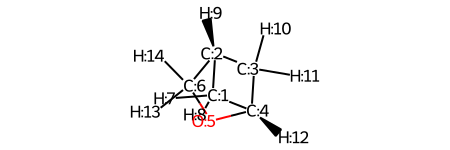

the initial prodcuts:


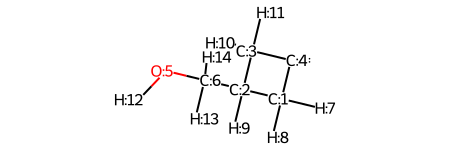

the outcomes is:


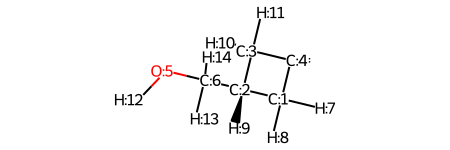

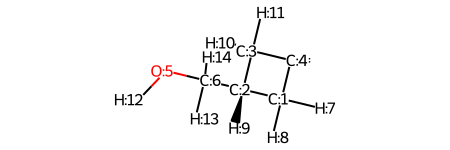

 this is the 317 reactions: 
the initial reactants:


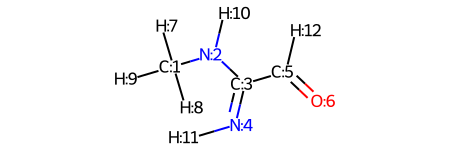

the initial prodcuts:


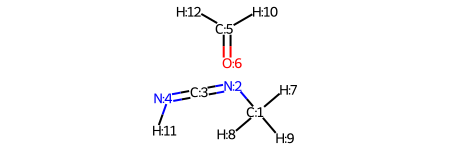

the outcomes is:


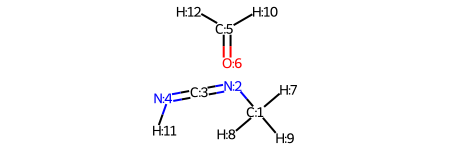

 this is the 335 reactions: 
the initial reactants:


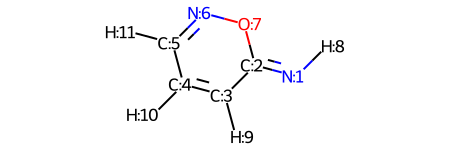

the initial prodcuts:


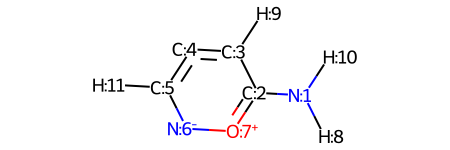

the outcomes is:
 this is the 364 reactions: 
the initial reactants:


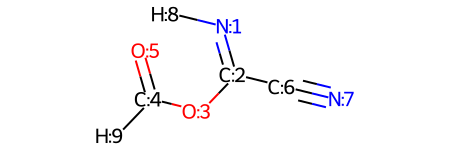

the initial prodcuts:


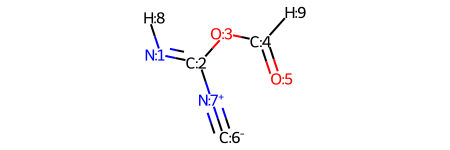

the outcomes is:


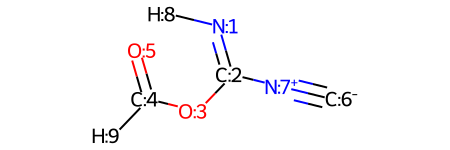

 this is the 388 reactions: 
the initial reactants:


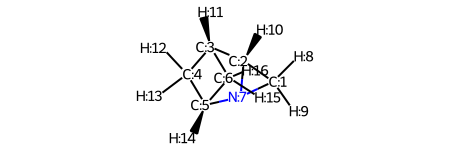

the initial prodcuts:


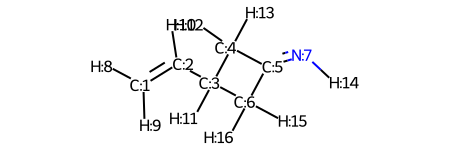

the outcomes is:


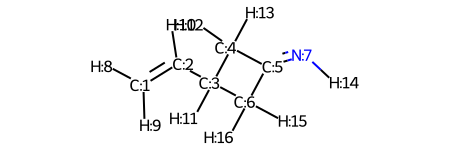

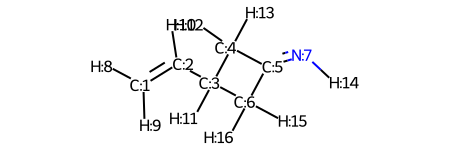

 this is the 393 reactions: 
the initial reactants:


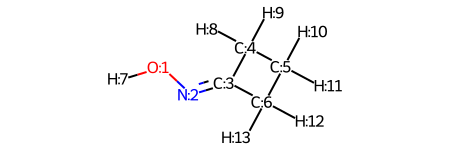

the initial prodcuts:


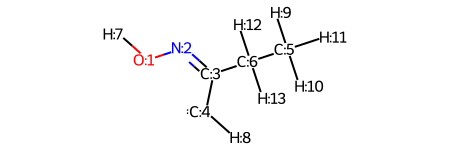

the outcomes is:


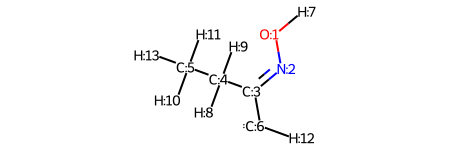

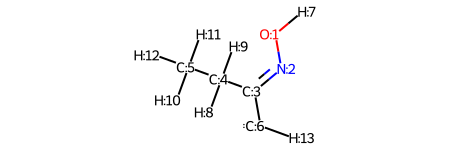

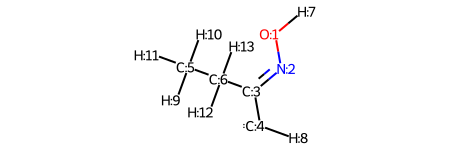

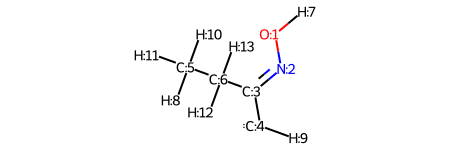

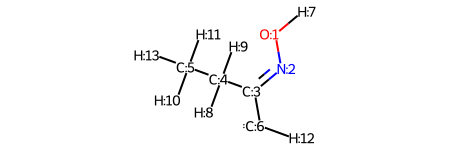

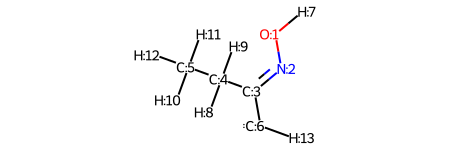

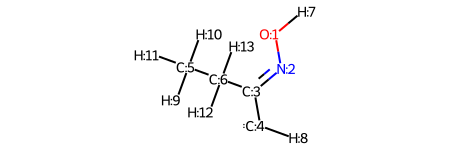

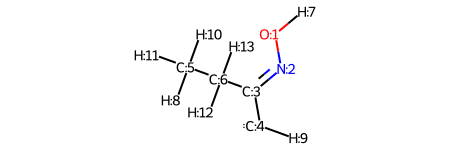

 this is the 442 reactions: 
the initial reactants:


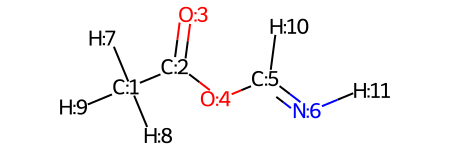

the initial prodcuts:


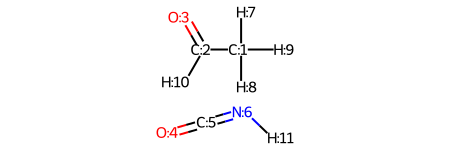

the outcomes is:


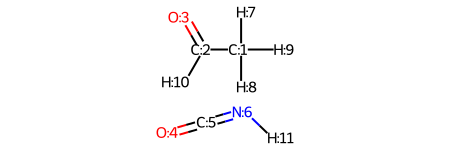

 this is the 447 reactions: 
the initial reactants:


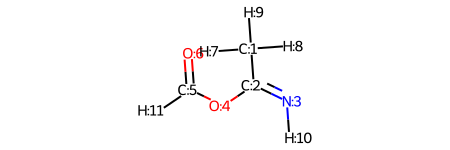

the initial prodcuts:


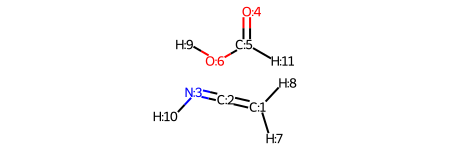

the outcomes is:


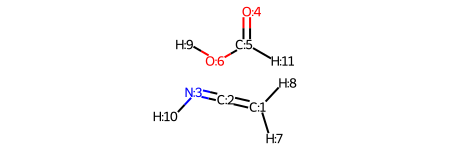

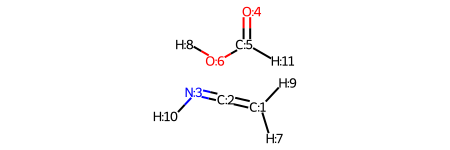

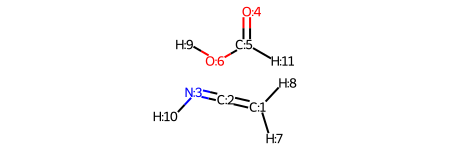

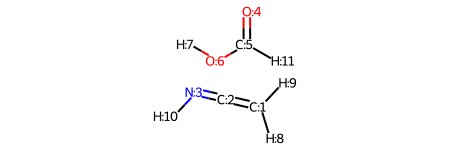

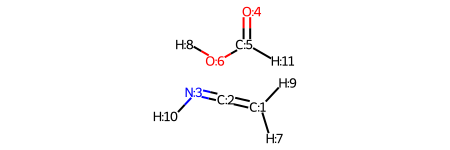

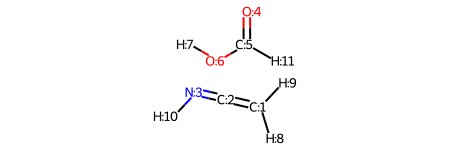

 this is the 457 reactions: 
the initial reactants:


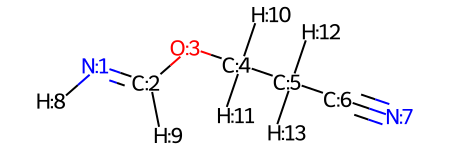

the initial prodcuts:


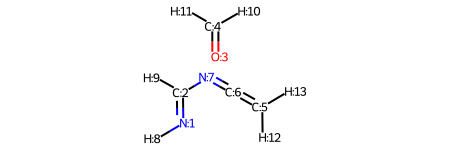

the outcomes is:


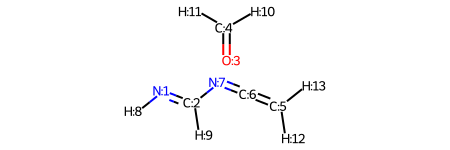

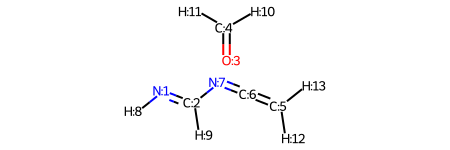

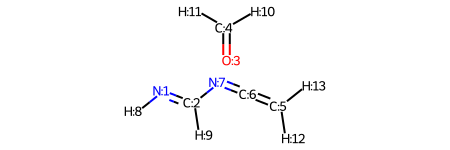

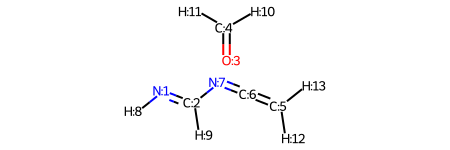

In [5]:
for i, outs in err.items():
    print(' this is the {} reactions: '.format(i))
    print('the initial reactants:')
    react_mol =  str_to_mol(reactions[i]['reactants'])
    display(react_mol)
    print('the initial prodcuts:')
    prods_mol = str_to_mol(outs[0])
    display(prods_mol)
    
    print('the outcomes is:')
    for out in outs[1]:
        if type(out) == list:
            for prod in out:
                out_mol = str_to_mol(prod)
                display(out_mol)
        else:
            out_mol = str_to_mol(out)
            display(out_mol)